# Summarize model performances

This notebooks plots the performances (using averaged ROC AUC scores) for models
trained with different training sets.

### Determine run parameters

In [1]:
# ----------------- Parameters for interactive development --------------
P = {
    "pipeline.run_environment": "dev",
}

In [2]:
# - During automated runs parameters will be injected in the below cell -

In [3]:
# Parameters
P = {
    "pipeline.data_lake_root": "/pipeline-outputs/data-lake",
    "pipeline.run_environment": "ci",
    "pipeline.pipeline_run_id": "8399d3a4-a048-40cf-ad89-57f36b387494",
    "pipeline.github.repository": "matiasdahl/dev-mnist-digits-demo-pipeline",
    "pipeline.github.workflow": "Run automated tests, pipeline and deploy results to static reporting site",
    "pipeline.github.runner_name": "Hosted Agent",
    "pipeline.github.run_id": "3645923404",
    "pipeline.github.actor": "matiasdahl",
    "pipeline.github.job": "run-tests-pipeline-and-persist-pipeline-outputs",
    "pipeline.github.base_ref": "",
    "pipeline.github.head_ref": "",
    "pipeline.github.sha": "ace0d01011d5e914f1921450dd5a59c11367b38d",
    "pipeline.github.ref": "refs/heads/development",
    "pipeline.github.ref_type": "branch",
    "pipeline.github.ref_name": "development",
    "pipeline.github.event_name": "schedule",
    "task.notebook": "notebooks/summary.py",
    "task.max_nr_retries": "1",
    "run.retry_nr": "0",
    "task.timeout_s": "None",
    "task.num_cpus": 1,
    "_opentelemetry_traceparent": "00-2d2770f1382e84497779055bc8562e6a-7bc39f7175acb18a-01",
}


In [4]:
# -----------------------------------------------------------------------

---

### Notebook code

In [5]:
#
import pandas as pd
import matplotlib.pyplot as plt

#
from pynb_dag_runner.tasks.task_opentelemetry_logging import PydarLogger

In [6]:
logger = PydarLogger(P=P)

2022-12-08 06:43:05,378	INFO worker.py:842 -- Connecting to existing Ray cluster at address: 172.17.0.2:6379


In [7]:
from pynb_dag_runner.tasks.task_opentelemetry_logging import (
    PydarLogger,
    get_logged_values,
)
from pynb_dag_runner.opentelemetry_helpers import _get_all_spans, Spans

In [8]:
def get_model_benchmarks():
    """
    Query the OpenTelemetry logs for *this pipeline run* and return
    all key-values logged from all runs of the benchmark-model.py task

    For testing a json file with OpenTelemetry spans (as an array)
    can be used as follows:

    - Create output directory `mkdir /tmp/spans`
    - Run unit tests. This will create pipeline-outputs/opentelemetry-spans.json
    - Convert this json-array into jsonl format as follows

    jq -c '.[]' /pipeline-outputs/opentelemetry-spans.json > /tmp/spans/data.txt

    """
    spans: Spans = Spans(_get_all_spans())
    print(f"Found {len(spans)} spans")

    benchmark_spans = (
        spans
        # -
        .filter(["name"], "execute-task")
        # -
        .filter(["attributes", "task.notebook"], "notebooks/benchmark-model.py")
    )

    result = []
    for s in benchmark_spans:
        result.append(
            {
                "span_id": s["context"]["span_id"],
                "nr_train_images": s["attributes"]["task.nr_train_images"],
                "data": get_logged_values(spans.bound_under(s)),
            }
        )

    return result


def adjust_pandas(df):
    def column_renamer(col_name: str) -> str:
        return (
            col_name
            # -- 'data.roc_auc_per_digit.4' -> 'roc_auc.4'
            .replace("data.roc_auc_per_digit", "roc_auc")
            # -- 'data.roc_auc_class_mean' -> 'roc_auc_mean'
            .replace("data.roc_auc_class_mean", "roc_auc_mean")
        )

    return df.rename(column_renamer, axis="columns").sort_values(by="nr_train_images")

In [9]:
df_data = adjust_pandas(pd.json_normalize(get_model_benchmarks()))

Found 420 spans


In [10]:
df_data.round(4)

,span_id,nr_train_images,roc_auc_mean,roc_auc.0,roc_auc.1,roc_auc.2,roc_auc.3,roc_auc.4,roc_auc.5,roc_auc.6,roc_auc.7,roc_auc.8,roc_auc.9
2,0x33213f2667a2b45c,600,0.9990,1.0,0.9992,1.0,0.9998,0.9991,0.9988,0.9999,0.9998,0.9946,0.9988
3,0x02eda1e9c8e094ef,800,0.9989,1.0,0.9988,1.0,0.9998,0.9995,0.9992,1.0000,0.9999,0.9927,0.9994
1,0x9b1d3d585c98d82b,1000,0.9992,1.0,0.9990,1.0,0.9999,0.9997,0.9994,0.9999,0.9998,0.9951,0.9996
0,0xc4286012447af252,1200,0.9994,1.0,0.9991,1.0,0.9999,0.9997,0.9997,0.9999,0.9998,0.9959,0.9998


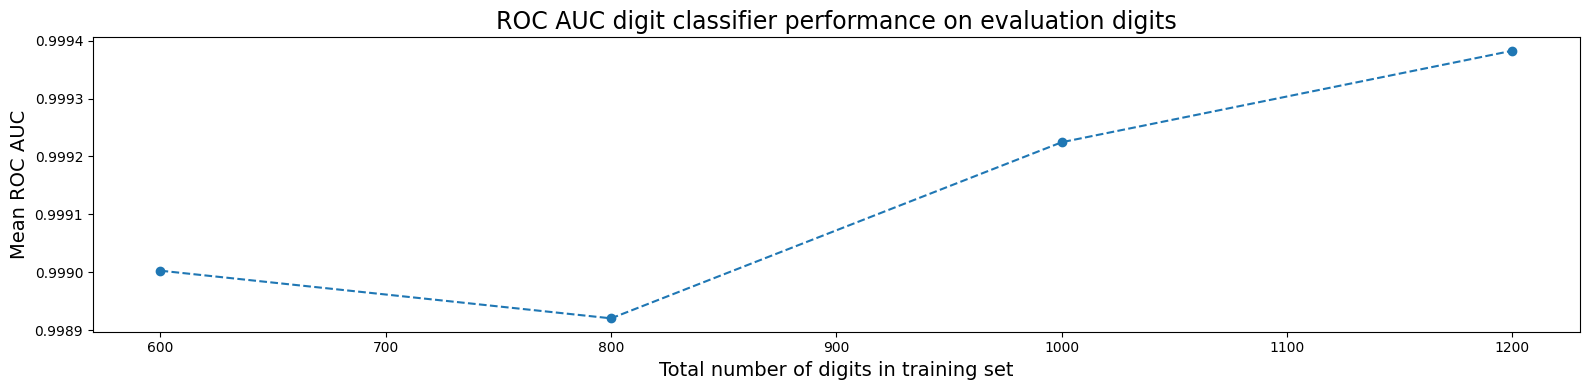

In [11]:
def plot_classifier_performance_summary(df_data):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4), sharex=True)

    #
    ax.plot(
        df_data["nr_train_images"], df_data["roc_auc_mean"], marker="o", linestyle="--"
    )
    ax.set_title(
        f"ROC AUC digit classifier performance on evaluation digits", fontsize=17
    )
    ax.set_xlabel("Total number of digits in training set", fontsize=14)
    ax.set_ylabel("Mean ROC AUC", fontsize=14)

    fig.tight_layout()
    fig.show()

    return fig


fig = plot_classifier_performance_summary(df_data)

In [12]:
logger.log_figure("auc-roc-model-performances.png", fig)

In [13]:
###